In [10]:
import os
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

from params import params_cae, params_snn, params_train
import snn_class 
import utils_ext
from train_eval import train_fn, evaluate

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

# Define useful variables
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64

In [2]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

Using cuda device


#### Note
Confrontare il nostro approccio (encoding a parte regolarizzato) con rete SNN che prende in input la CIR e fa direttamente la classificazione. In questo caso NON usare regolarizzazione sul numero di spikes, perché il contributo che vogliamo mostrare è proprio quello sulla regolarizzazione

In [30]:
def train_fn(model, train, valid, optimizer, epochs, patience, path, verbose = True):
    
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list   = [], []
    counter = 0
    best_val_acc = -float('inf')
    loss_fn_snn = SF.ce_count_loss() 

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
            model.train()
            train_loss, train_acc = 0.0, 0.0
            optimizer.zero_grad()

            for batch, (X, muD, y) in enumerate(train):
                del muD
                X, y = X.squeeze().to(device), y.squeeze().to(device)

                spk_out = model(X.float())
                #print(spk_out.shape)
                #print(torch.sum(spk_out, 0).shape)
                clss = torch.argmax(torch.sum(spk_out, 0), dim=1)
                #print(clss.shape)
                #print(y.shape)
                       
                train_acc += (sum(clss==y)/len(y)).cpu().item()

                loss = loss_fn_snn(spk_out, y)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                train_loss += loss.item()
               
            train_loss_list.append(train_loss/len(train))
            train_acc_list.append(train_acc/len(train))

            with torch.no_grad():
                model.eval()
                val_loss = 0.0
                val_acc = 0.0

                for batch, (X, muD, y) in enumerate(valid):
                    del muD
                    X, y = X.squeeze().to(device), y.squeeze().to(device)

                    spk_out = model(X.float())
                    clss = torch.argmax(torch.sum(spk_out, 0), dim=1)
                    val_acc += (sum(clss==y)/len(y)).cpu().item()

                    loss = loss_fn_snn(spk_out, y) 
                    val_loss += loss.item()

                val_loss_list.append(val_loss / len(valid))
                val_acc_list.append(val_acc / len(valid))
            
                if val_acc_list[-1] > best_val_acc:
                    best_val_acc = val_acc_list[-1]
                    counter = 0
                    if path:
                        torch.save(model.state_dict(), path)

                else:
                    counter += 1
                
                if counter >= patience:
                    print(f'Early stopping at epoch {epoch}')
                    break

            torch.cuda.empty_cache()

            if verbose:
                print(f"Epoch {epoch+1} - loss: {round(train_loss_list[-1], 4)} | acc: {round(train_acc_list[-1], 4)} | val_loss: {round(val_loss_list[-1], 4)} | val_acc: {round(val_acc_list[-1], 4)}")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


In [8]:
SHAPE = (2, 232, 10, 64)

In [33]:
clssf =  snn_class.snn_classifier(
                    input_dim = SHAPE, 
                    timesteps = N_WIN,
                    hidden = [128,64], 
                    n_classes = 4, 
                    surr_grad = surrogate.fast_sigmoid(),
                    learn_thr = True, 
                    learn_beta = True
                    ).to(device)
    
optimizer = torch.optim.Adam(clssf.parameters(), lr = 1e-4)

train_loss, val_loss, train_acc, val_acc = train_fn(
                                                  model = clssf, 
                                                  train = train_loader, 
                                                  valid = val_loader,
                                                  optimizer = optimizer,
                                                  epochs = 100, 
                                                  patience = 10, 
                                                  path = 'models/model_snn_clssf.pt'
                                                  )

Epoch 1 - loss: 1.3029 | acc: 0.4579 | val_loss: 1.6569 | val_acc: 0.4914
Epoch 2 - loss: 0.9677 | acc: 0.5997 | val_loss: 1.0711 | val_acc: 0.5905
Epoch 3 - loss: 0.5713 | acc: 0.7935 | val_loss: 0.6769 | val_acc: 0.7371
Epoch 4 - loss: 0.4598 | acc: 0.8652 | val_loss: 0.4567 | val_acc: 0.8578
Epoch 5 - loss: 0.4841 | acc: 0.842 | val_loss: 0.5753 | val_acc: 0.7931
Epoch 6 - loss: 0.3015 | acc: 0.9059 | val_loss: 0.2661 | val_acc: 0.9267
Epoch 7 - loss: 0.334 | acc: 0.8982 | val_loss: 0.334 | val_acc: 0.8707
Epoch 8 - loss: 0.277 | acc: 0.9101 | val_loss: 0.3706 | val_acc: 0.8966
Epoch 9 - loss: 0.2736 | acc: 0.927 | val_loss: 0.1789 | val_acc: 0.9267
Epoch 10 - loss: 0.261 | acc: 0.9312 | val_loss: 0.319 | val_acc: 0.8966
Epoch 11 - loss: 0.1792 | acc: 0.9459 | val_loss: 0.2493 | val_acc: 0.9224
Epoch 12 - loss: 0.2936 | acc: 0.908 | val_loss: 0.3066 | val_acc: 0.8922
Epoch 13 - loss: 0.2826 | acc: 0.9171 | val_loss: 0.3054 | val_acc: 0.9138
Epoch 14 - loss: 0.2525 | acc: 0.9249 | va

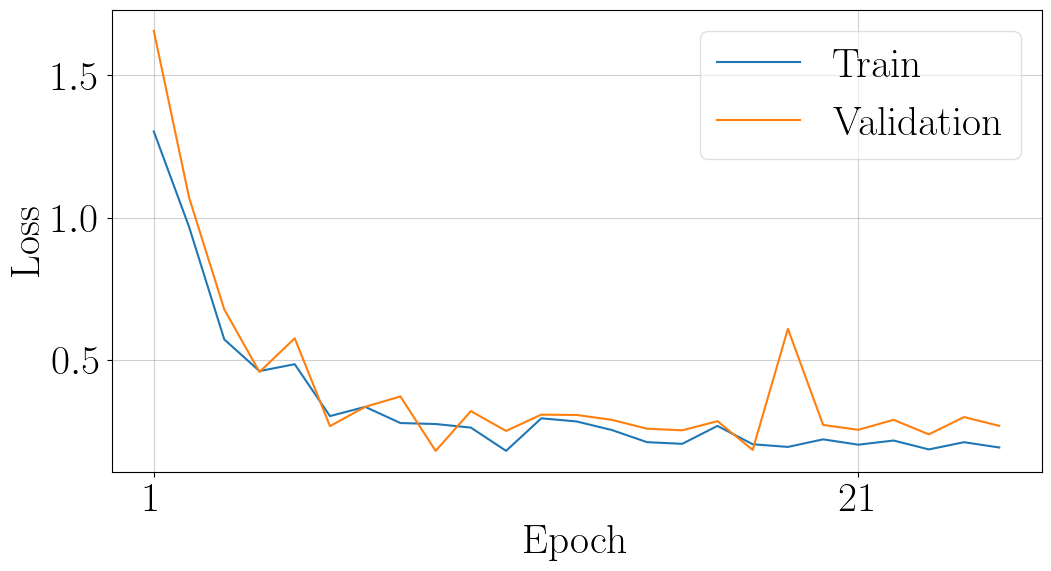

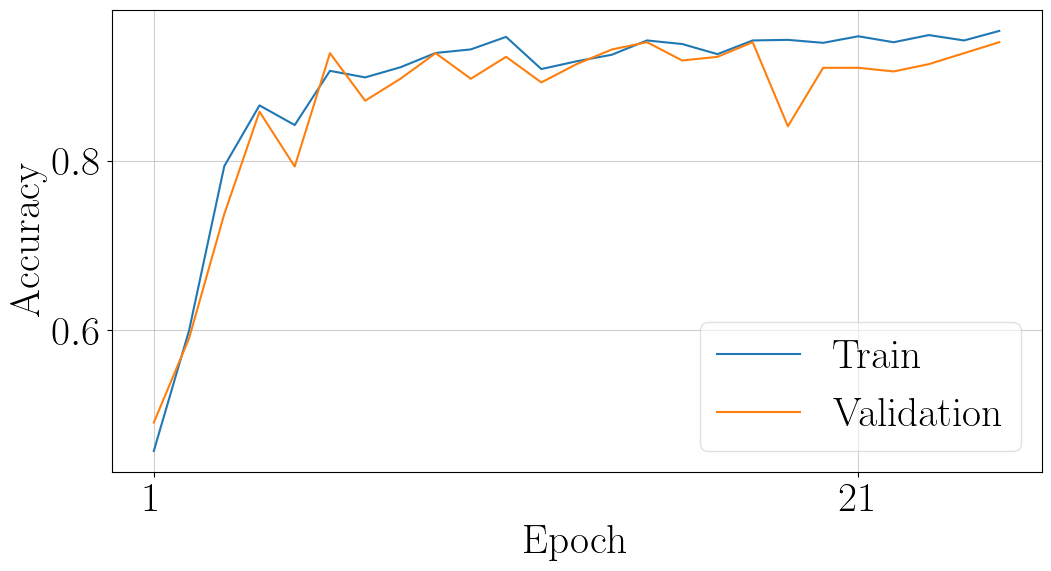

In [34]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_loss.png", bbox_inches='tight')
plt.show()

plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_acc.png", bbox_inches='tight')
plt.show()

In [35]:
path = "models/model_snn_clssf.pt"

clssf.load_state_dict(torch.load(path))
clssf.eval()

snn_classifier(
  (fc_in): Linear(in_features=64, out_features=128, bias=True)
  (lif_in): Leaky()
  (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
  (lif_hidden): Leaky()
  (fc_out): Linear(in_features=1280, out_features=4, bias=True)
  (li_out): Leaky()
)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, confusion_matrix, classification_report,\
                            balanced_accuracy_score

In [38]:
def evaluate(model, dataloader, avg_type, verbose=True):
    model.eval()
    ground_truth, predictions = [], []

    with torch.no_grad():
        for X, _, y in dataloader:
            X = X.to(device)
        
            ground_truth.append(y.item())
            spk_out = model(X.float())
            clss = torch.argmax(torch.sum(spk_out, 0), dim=1) 
            predictions.append(clss.to("cpu").item())

    if avg_type == 'macro':
        accuracy = round(accuracy_score(ground_truth, predictions), 4)
    else:
        accuracy = round(balanced_accuracy_score(ground_truth, predictions), 4)
        
    precision = round(precision_score(ground_truth, predictions, average=avg_type), 4)
    recall = round(recall_score(ground_truth, predictions, average=avg_type), 4)
    F1 = round(f1_score(ground_truth, predictions, average=avg_type),4)

    confusion_mx = confusion_matrix(ground_truth, predictions)
    report = classification_report(ground_truth, predictions,
                                   target_names=['WALKING', 'RUNNING', 'SITTING', 'HANDS'])
    print(F"AVERAGE TYPE: {avg_type}\n")
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {F1}")
    if verbose:
        print("\nClassification Report:\n", report)

    return accuracy, precision, recall, F1, confusion_mx

In [39]:
acc, prec, rec, f1, conf_mx = evaluate(clssf, test_loader, 
                                    avg_type='macro', verbose=False)

AVERAGE TYPE: macro

Accuracy: 0.9267
Precision: 0.9211
Recall: 0.9232
F1 score: 0.9212


In [41]:
acc1, prec1, rec1, f11, conf_mx1 = evaluate(clssf, test_loader, 
                                    avg_type='weighted', verbose=True)

AVERAGE TYPE: weighted

Accuracy: 0.9232
Precision: 0.9284
Recall: 0.9267
F1 score: 0.927

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.93      0.94      0.93       125
     RUNNING       0.95      0.89      0.92        44
     SITTING       0.97      0.94      0.96        36
       HANDS       0.83      0.93      0.88        27

    accuracy                           0.93       232
   macro avg       0.92      0.92      0.92       232
weighted avg       0.93      0.93      0.93       232

